In [18]:
# Importing datasets
import pandas as pd
import numpy as np
from fbprophet import Prophet
# Read train and test
train = pd.read_csv('Train_SU63ISt.csv')
test = pd.read_csv('Test_0qrQsBZ.csv')

%matplotlib inline

# Convert to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
train['hour'] = train.Datetime.dt.hour

In [19]:
# Calculate average hourly fraction
hourly_frac = train.groupby(['hour']).mean()/np.sum(train.groupby(['hour']).mean())
hourly_frac.drop(['ID'], axis = 1, inplace = True)
hourly_frac.columns = ['fraction']


# convert to time series from dataframe
train.index = train.Datetime
train.drop(['ID','hour','Datetime'], axis = 1, inplace = True)

daily_train = train.resample('D').sum()

In [20]:
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train.Count
daily_train.drop(['Count'],axis = 1, inplace = True)

In [21]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


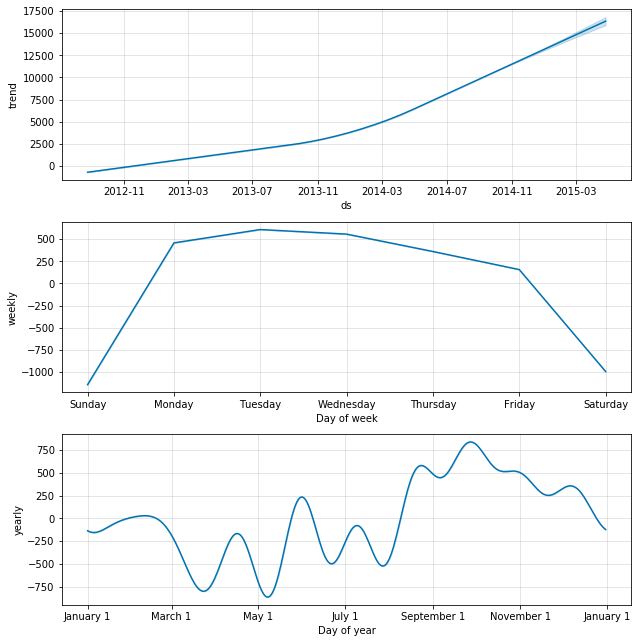

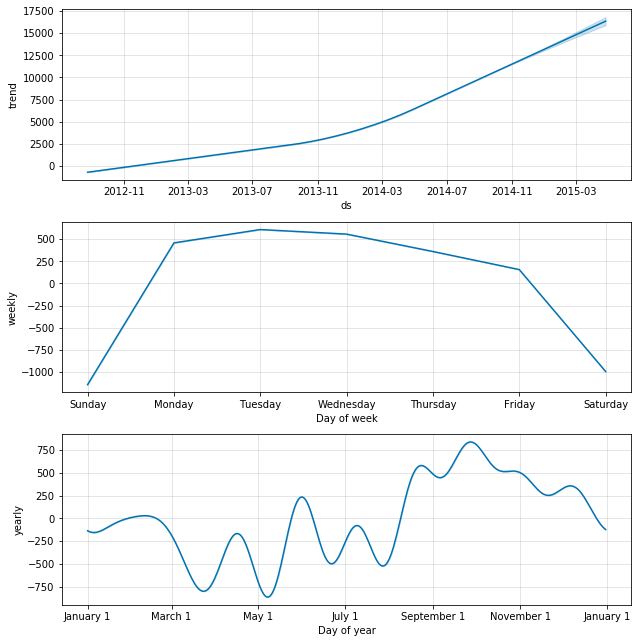

In [22]:
m.plot_components(forecast)

In [24]:
# Extract hour, day, month and year from both dataframes to merge
for df in [test, forecast]:
    df['hour'] = df.Datetime.dt.hour
    df['day'] = df.Datetime.dt.day
    df['month'] = df.Datetime.dt.month
    df['year'] = df.Datetime.dt.year

# Merge forecasts with given IDs
test = pd.merge(test,forecast, on=['day','month','year'], how='left')
cols = ['ID','hour','yhat']
test_new = test[cols]

# Merging hourly average fraction to the test data
test_new = pd.merge(test_new, hourly_frac, left_on = ['hour'], right_index=True, how = 'left')
# Convert daily aggregate to hourly traffic
test_new['Count'] = test_new['yhat'] * test_new['fraction']
test_new.drop(['yhat','fraction','hour'],axis = 1, inplace = True)
test_new.to_csv('prophet_sub.csv',index = False)


AttributeError: 'DataFrame' object has no attribute 'Datetime'